# Thư viện

In [ ]:
!pip install h5py -q
!pip install tf-keras -q

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from matplotlib import pyplot as plt
import tensorflow as tf
import scipy.io
import sys

# Kiểm tra phiên bản
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
try:
    import tf_keras
    print(f"tf_keras package version (if found): {tf_keras.__version__}")
except ImportError:
    print("tf_keras package not directly importable or TF_USE_LEGACY_KERAS not fully effective yet.")
except AttributeError:
    print("tf_keras package found, but no __version__ attribute (typical for Keras 2 via tf.keras). Using tf.keras directly.")
    print(f"Effective tf.keras path: {tf.keras}")
sys.path.append('/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/') # Thay đổi đường dẫn này nếu cần

from utils2 import *

TensorFlow version: 2.18.0
NumPy version: 2.0.2
tf_keras package version (if found): 2.18.0


# 2x32

# Model

In [ ]:
def create_2x32_model():
    """Hàm xây dựng kiến trúc model 2x32."""
    Nt, Nr = 32, 2
    imperfect_CSI_input_layer = Input(name='imperfect_CSI_input', shape=(2*Nr*Nt,), dtype=tf.float32)
    perfect_CSI_input_layer = Input(name='perfect_CSI_input', shape=(Nr, Nt), dtype=tf.complex64)
    SNR_keras_input_layer = Input(name='SNR_keras_input', shape=(1,), dtype=tf.float32)

    x = Dense(256, activation='relu', name='dense_1')(imperfect_CSI_input_layer)
    x = BatchNormalization(name='bn_1')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = Dense(128, activation='relu', name='dense_2')(x)
    x = BatchNormalization(name='bn_2')(x)

    # Các lớp tạo pha
    phase_f_sigmoid = Dense(Nt, activation='sigmoid', name='phase_f_sigmoid_dense')(x)
    phase_f_scaled = Lambda(lambda x: x * 2 * np.pi, name='phase_f_scaled_lambda')(phase_f_sigmoid)

    phase_w_sigmoid = Dense(Nr, activation='sigmoid', name='phase_w_sigmoid_dense')(x)
    phase_w_scaled = Lambda(lambda x: x * 2 * np.pi, name='phase_w_scaled_lambda')(phase_w_sigmoid)

    F_RF_output = Lambda(lambda x: trans_Vrf(x, Nt), name='F_RF_lambda')(phase_f_scaled)
    W_RF_output = Lambda(lambda x: trans_Vrf(x, Nr), name='W_RF_lambda')(phase_w_scaled)

    Nt_tf_const = tf.constant(float(Nt), dtype=tf.float32)
    Nr_tf_const = tf.constant(float(Nr), dtype=tf.float32)

    rate_output = Lambda(Rate_func_MIMO, name='rate_output_lambda')(
        [perfect_CSI_input_layer, F_RF_output, W_RF_output, SNR_keras_input_layer, Nt_tf_const, Nr_tf_const]
    )
    model = Model(
        inputs=[imperfect_CSI_input_layer, perfect_CSI_input_layer, SNR_keras_input_layer],
        outputs=rate_output
    )
    return model

Đang tải dữ liệu cho cấu hình 2x32 từ: /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/2x32/train
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (100000, 2, 32)
Shape của H_input_data (imperfect CSI đã xử lý): (100000, 128)
Shape của H_data (perfect CSI): (100000, 2, 32)
Shape của SNR_data: (100000, 1)

Model Summary cho cấu hình 2x32:
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imperfect_CSI_input (Input  [(None, 128)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 dense_1 (Dense)             (None, 256)                  33024     ['imperfect_CSI_input[0][0]'] 
   

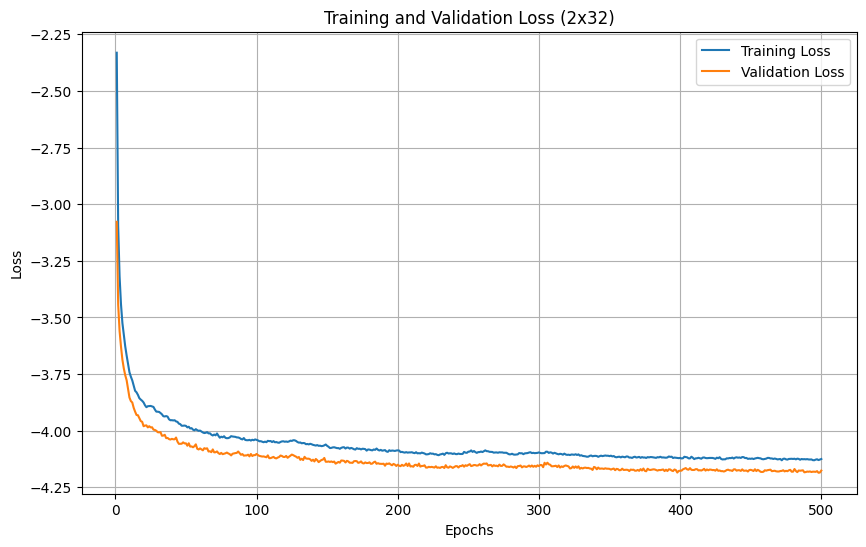

In [ ]:
# --- ĐỊNH NGHĨA CẤU HÌNH 2x32 ---
Nt = 32
Nr = 2
# --- KẾT THÚC ĐỊNH NGHĨA CẤU HÌNH ---


path = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/2x32/train' # Đường dẫn
print(f"Đang tải dữ liệu cho cấu hình {Nr}x{Nt} từ: {path}")
H_data, H_est_data= mat_load_train(path)

if H_data is None or H_est_data is None:
    print("Lỗi khi tải dữ liệu. Dừng chương trình.")
    sys.exit()
else:
    # Chuẩn bị H_input (đã làm phẳng)
    H_input_real_data = np.real(H_est_data).reshape(H_est_data.shape[0], -1)
    H_input_imag_data = np.imag(H_est_data).reshape(H_est_data.shape[0], -1)
    H_input_data = np.concatenate([H_input_real_data, H_input_imag_data], axis=1)
    print(f"Shape của H_input_data (imperfect CSI đã xử lý): {H_input_data.shape}")

    # H (perfect CSI) có shape (số_mẫu, Nr, Nt) từ mat_load
    print(f"Shape của H_data (perfect CSI): {H_data.shape}")

    # Generate SNRs
    SNR_data = np.power(10, np.random.randint(-20, 20, [H_data.shape[0], 1]) / 10).astype(np.float32)
    print(f"Shape của SNR_data: {SNR_data.shape}")

    model = create_2x32_model()

    optimizer_adam = Adam(learning_rate=0.001) # Đặt tên biến optimizer rõ ràng
    model.compile(optimizer=optimizer_adam, loss=lambda y_true, y_pred: y_pred)
    print("\nModel Summary cho cấu hình 2x32:")
    model.summary()

    # --- Train Model ---
    checkpoint_filepath = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/2x32/2x32_20dB.weights.h5' # Đổi tên thư mục lưu weights
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        save_weights_only=True
    )

    dummy_y_train = np.zeros((H_input_data.shape[0], 1))

    print(f"\nBắt đầu huấn luyện model cho cấu hình {Nr}x{Nt}...")
    history = model.fit(x=[H_input_data, H_data, SNR_data],
                        y=dummy_y_train,
                        batch_size=256,
                        epochs=500,
                        verbose=2,
                        validation_split=0.1,
                        callbacks=[checkpoint]
                       )
    print(f"Đã huấn luyện xong. Trọng số tốt nhất được lưu tại: {checkpoint_filepath}")
 # --- Vẽ Đồ Thị Loss ---
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs_range = range(1, len(training_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss ({Nr}x{Nt})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

**Test 2x32**


Đã xây dựng lại kiến trúc model 2x32 cho việc test.



Đã tải trọng số từ: /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/0dB/2x32/2x32_0dB.weights.h5
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (10000, 2, 32)

Bắt đầu đánh giá trên tập test...
SNR: -20dB, Loss (Negative SE): -0.13466759026050568
SNR: -15dB, Loss (Negative SE): -0.37008222937583923
SNR: -10dB, Loss (Negative SE): -0.8648051023483276
SNR: -5dB, Loss (Negative SE): -1.6590361595153809
SNR: 0dB, Loss (Negative SE): -2.70100474357605
SNR: 5dB, Loss (Negative SE): -3.9321539402008057
SNR: 10dB, Loss (Negative SE): -5.310042858123779
SNR: 15dB, Loss (Negative SE): -6.794956207275391
SNR: 20dB, Loss (Negative SE): -8.35078239440918

Kết quả Spectral Efficiency trên tập test: [0.13466759026050568, 0.37008222937583923, 0.8648051023483276, 1.6590361595153809, 2.70100474357605, 3.9321539402008057, 5.310042858123779, 6.794956207275391, 8.35078239440918]


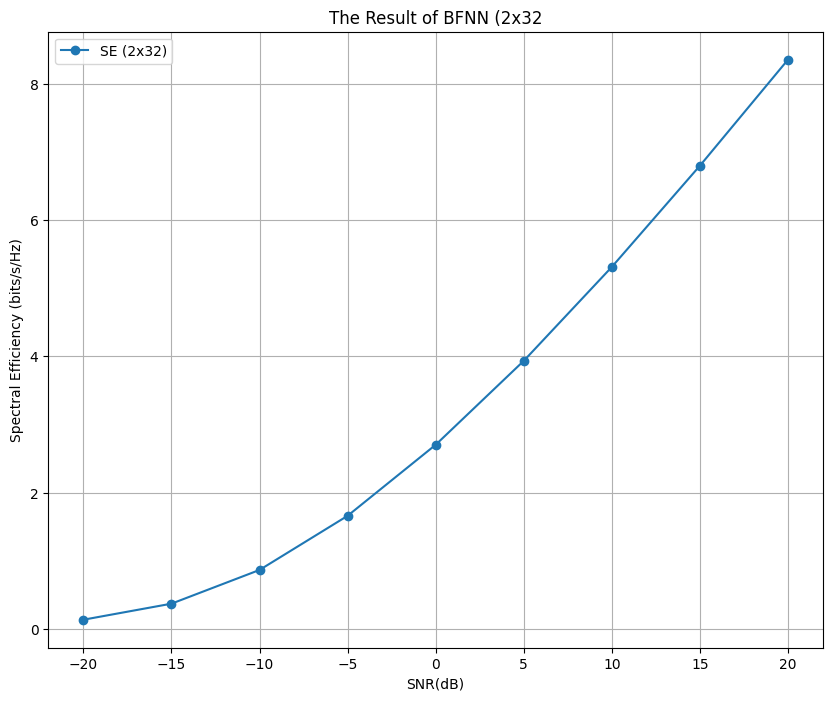

In [ ]:
Nt = 32
Nr = 2

model_for_test = create_2x32_model()

optimizer = Adam(learning_rate=0.001) # Learning rate ở đây không ảnh hưởng đến trọng số
model_for_test.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
print("Đã xây dựng lại kiến trúc model 2x32 cho việc test.")


# --- TẢI TRỌNG SỐ ĐÃ LƯU ---
weights_path = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/0dB/2x32/2x32_0dB.weights.h5'
try:
    model_for_test.load_weights(weights_path)
    print(f"\nĐã tải trọng số từ: {weights_path}")
except Exception as e:
    print(f"\nLỖI khi tải trọng số: {e}. Hãy đảm bảo đường dẫn đúng và kiến trúc model khớp.")
else:
    # ---CHUẨN BỊ DỮ LIỆU TEST ---
    path_test_data = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/10dB/2x32/test'
    H_test_perfect, H_test_estimated,_,_,_ = mat_load_test(path_test_data)

    if H_test_perfect is not None:
        H_input_test_real = np.real(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
        H_input_test_imag = np.imag(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
        H_input_for_testing = np.concatenate([H_input_test_real, H_input_test_imag], axis=1)

        H_perfect_for_testing = H_test_perfect

        num_test_samples = H_input_for_testing.shape[0]
        dummy_y_test = np.zeros((num_test_samples, 1))

        # --- TEST ---
        rate_results = []
        snr_db_range = range(-20, 21, 5)

        print("\nBắt đầu đánh giá trên tập test...")
        for snr_db_value in snr_db_range:
            SNR_for_evaluation = np.power(10, np.ones([num_test_samples, 1]) * snr_db_value / 10.0).astype(np.float32)

            loss_value = model_for_test.evaluate(
                x=[H_input_for_testing, H_perfect_for_testing, SNR_for_evaluation],
                y=dummy_y_test,
                batch_size=256,
                verbose=0
            )
            print(f"SNR: {snr_db_value}dB, Loss (Negative SE): {loss_value}")
            rate_results.append(-loss_value)

        print("\nKết quả Spectral Efficiency trên tập test:", rate_results)

        # --- VẼ ĐỒ THỊ KẾT QUẢ ---
        plt.figure(figsize=(10, 8))
        plt.title(f"The Result of BFNN ({Nr}x{Nt}")
        plt.xlabel("SNR(dB)")
        plt.ylabel("Spectral Efficiency (bits/s/Hz)")
        plt.plot(list(snr_db_range), rate_results, marker='o', linestyle='-', label=f'SE ({Nr}x{Nt})')
        plt.xticks(list(snr_db_range))
        plt.legend()
        plt.grid(True)
        plt.show()

# 4x64 Model


In [6]:
def create_4x64_model():

    Nt = 64
    Nr = 4
    imperfect_CSI_input_layer = Input(name='imperfect_CSI_input', shape=(2*Nr*Nt,), dtype=tf.float32)
    perfect_CSI_input_layer = Input(name='perfect_CSI_input', shape=(Nr, Nt), dtype=tf.complex64)
    SNR_keras_input_layer = Input(name='SNR_keras_input', shape=(1,), dtype=tf.float32)

    temp = Dense(512, activation='relu', name='dense_1')(imperfect_CSI_input_layer)
    temp = tf.keras.layers.BatchNormalization(name='bn_1')(temp)
    temp = Dense(256, activation='relu', name='dense_2')(temp)
    temp = tf.keras.layers.BatchNormalization(name='bn_2')(temp)
    temp = tf.keras.layers.Dropout(0.4)(temp)

    temp = Dense(128, activation='relu', name='dense_3')(temp)
    temp = tf.keras.layers.BatchNormalization(name='bn_3')(temp)
    temp = tf.keras.layers.Dropout(0.3)(temp)


    phase_f_sigmoid = Dense(Nt, activation='sigmoid', name='phase_f_sigmoid_dense')(temp) # Nt = 64
    phase_f_scaled = Lambda(lambda x: x * 2 * np.pi, name='phase_f_scaled_lambda')(phase_f_sigmoid)

    phase_w_sigmoid = Dense(Nr, activation='sigmoid', name='phase_w_sigmoid_dense')(temp) # Nr = 4
    phase_w_scaled = Lambda(lambda x: x * 2 * np.pi, name='phase_w_scaled_lambda')(phase_w_sigmoid)

    # SỬA LỖI: Sử dụng phase_f_scaled và phase_w_scaled
    F_RF_output = Lambda(lambda x: trans_Vrf(x, Nt), name='F_RF_lambda', output_shape=(Nt,))(phase_f_scaled)
    W_RF_output = Lambda(lambda x: trans_Vrf(x, Nr), name='W_RF_lambda', output_shape=(Nr,))(phase_w_scaled)

    Nt_tf_const = tf.constant(float(Nt), dtype=tf.float32)
    Nr_tf_const = tf.constant(float(Nr), dtype=tf.float32)

    rate_output = Lambda(Rate_func_MIMO, name='rate_output_lambda', output_shape=(1,), dtype=tf.float32)(
        [perfect_CSI_input_layer, F_RF_output, W_RF_output, SNR_keras_input_layer, Nt_tf_const, Nr_tf_const]
    )
    model = Model(inputs=[imperfect_CSI_input_layer, perfect_CSI_input_layer, SNR_keras_input_layer],
                  outputs=rate_output)

    return model

Đang tải dữ liệu cho cấu hình 4x64 từ: /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/4x64/train
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (100000, 4, 64)
Shape của H_input (imperfect CSI đã xử lý): (100000, 512)
Shape của H (perfect CSI): (100000, 4, 64)
Shape của SNR: (100000, 1)

Model Summary cho cấu hình 4x64:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ imperfect_CSI_input │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ imperfect_CSI_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ bn_2[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ bn_3[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phase_f_sigmoid_de… │ (None, 64)        │      8,256 │ dropout_15[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phase_w_sigmoid_de… │ (None, 4)         │        516 │ dropout_15[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phase_f_scaled_lam… │ (None, 64)        │          0 │ phase_f_sigmoid_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phase_w_scaled_lam… │ (None, 4)         │          0 │ phase_w_sigmoid_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ perfect_CSI_input   │ (None, 4, 64)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ F_RF_lambda         │ (None, 64)        │          0 │ phase_f_scaled_l… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_RF_lambda         │ (None, 4)         │          0 │ phase_w_scaled_l… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SNR_keras_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rate_output_lambda  │ (None, 1)         │          0 │ perfect_CSI_inpu

 Total params: 439,236 (1.68 MB)

 Trainable params: 437,444 (1.67 MB)

 Non-trainable params: 1,792 (7.00 KB)


Bắt đầu huấn luyện model cho cấu hình 4x64...
Epoch 1/500

Epoch 1: val_loss improved from inf to -2.52227, saving model to /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/4x64/4x64_20dB.weights.h5
352/352 - 9s - 25ms/step - loss: -1.3520e+00 - val_loss: -2.5223e+00 - learning_rate: 1.0000e-03
Epoch 2/500

Epoch 2: val_loss improved from -2.52227 to -3.34435, saving model to /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/4x64/4x64_20dB.weights.h5
352/352 - 6s - 18ms/step - loss: -2.3690e+00 - val_loss: -3.3444e+00 - learning_rate: 1.0000e-03
Epoch 3/500

Epoch 3: val_loss improved from -3.34435 to -3.72898, saving model to /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/4x64/4x64_20dB.weights.h5
352/352 - 10s - 29ms/step - loss: -2.9929e+00 - val_loss: -3.7290e+00 - learning_rate: 1.0000e-03
Epoch 4/500

Epoch 4: val_loss improved from -3.72898 to -3.95189, saving model to /content/drive/MyDrive/Kh

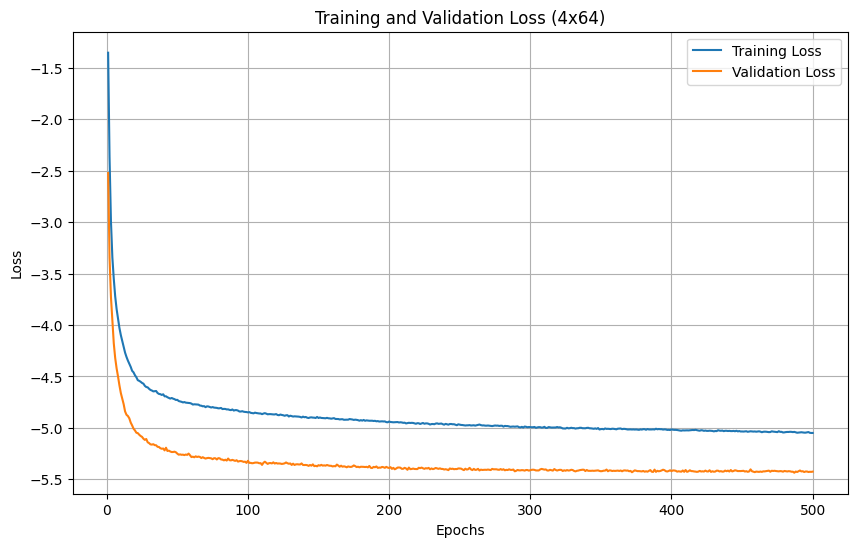

In [ ]:
Nt = 64
Nr = 4

path = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/4x64/train'
H, H_est = mat_load_train(path)

if H is None or H_est is None:
    import sys
    sys.exit()
else:
    H_input_real = np.real(H_est).reshape(H_est.shape[0], -1)
    H_input_imag = np.imag(H_est).reshape(H_est.shape[0], -1)
    H_input = np.concatenate([H_input_real, H_input_imag], axis=1)
    print(f"Shape của H_input (imperfect CSI đã xử lý): {H_input.shape}")
    print(f"Shape của H (perfect CSI): {H.shape}")

    SNR = np.power(10, np.random.randint(-20, 20, [H.shape[0], 1]) / 10).astype(np.float32)
    print(f"Shape của SNR: {SNR.shape}")

    # --- Construct the BFNN Model ---

    model = create_4x64_model()

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
    print("\nModel Summary cho cấu hình 4x64:")
    model.summary()

    # --- Train Your Model ---
    checkpoint_filepath = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/4x64/4x64_20dB_test.weights.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        save_weights_only=True
    )

    dummy_y = np.zeros((H_input.shape[0], 1))

    print(f"\nBắt đầu huấn luyện model cho cấu hình {Nr}x{Nt}...")
    history = model.fit(x=[H_input, H, SNR],
                        y=dummy_y,
                        batch_size=256,
                        epochs=500,
                        verbose=2,
                        validation_split=0.1,
                        callbacks=[checkpoint]
                       )

    print(f"Đã huấn luyện xong. Trọng số tốt nhất được lưu tại: {checkpoint_filepath}")
    # --- Vẽ Đồ Thị Loss ---
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs_range = range(1, len(training_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss ({Nr}x{Nt})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

**Test 4x64**



--- Model Summary được xây dựng lại cho 4x64 ---
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imperfect_CSI_input (Input  [(None, 512)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 dense_1 (Dense)             (None, 512)                  262656    ['imperfect_CSI_input[0][0]'] 
                                                                                                  
 bn_1 (BatchNormalization)   (None, 512)                  2048      ['dense_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 256)  


Đã tải trọng số từ: /content/drive/MyDrive/Datasets/test/20dB/4x64/4x64_20dB.weights.h5
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (10000, 4, 64)

Bắt đầu đánh giá trên tập test...
SNR: -20dB, Loss (Negative SE): -0.6248572468757629
SNR: -15dB, Loss (Negative SE): -1.3946508169174194
SNR: -10dB, Loss (Negative SE): -2.542872190475464
SNR: -5dB, Loss (Negative SE): -3.9421160221099854
SNR: 0dB, Loss (Negative SE): -5.4736456871032715
SNR: 5dB, Loss (Negative SE): -7.069481372833252
SNR: 10dB, Loss (Negative SE): -8.696797370910645
SNR: 15dB, Loss (Negative SE): -10.340130805969238
SNR: 20dB, Loss (Negative SE): -11.991827011108398

Kết quả Spectral Efficiency trên tập test: [0.6248572468757629, 1.3946508169174194, 2.542872190475464, 3.9421160221099854, 5.4736456871032715, 7.069481372833252, 8.696797370910645, 10.340130805969238, 11.991827011108398]


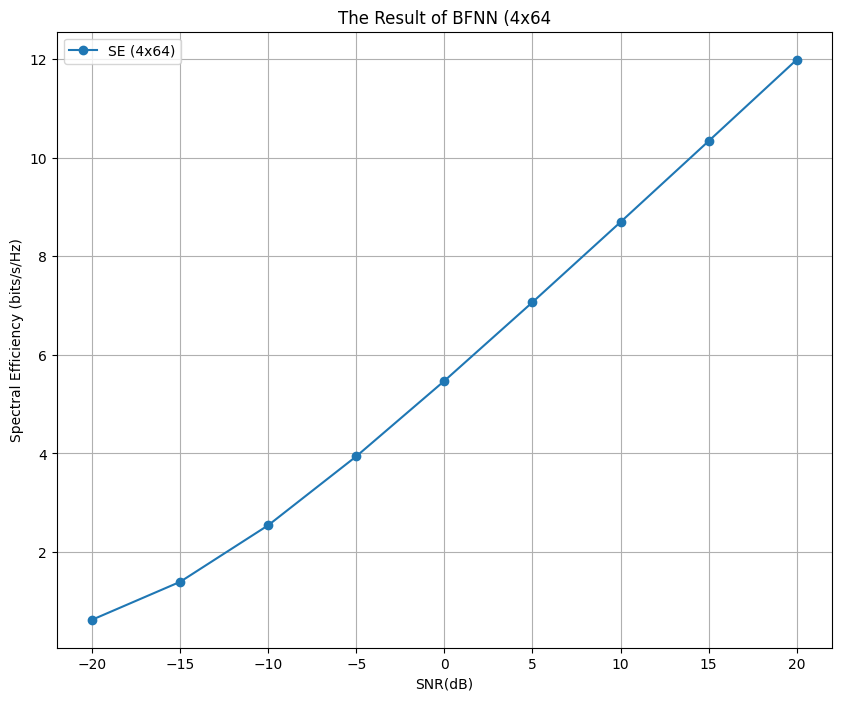

In [ ]:
Nt = 64
Nr = 4

model_for_test = create_4x64_model()

optimizer = Adam(learning_rate=0.001)
model_for_test.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
print("\n--- Model Summary được xây dựng lại cho 4x64 ---")
model_for_test.summary()

# --- TẢI TRỌNG SỐ VÀ CHUẨN BỊ DỮ LIỆU TEST ---
weights_path = f'/content/drive/MyDrive/Datasets/test/20dB/4x64/4x64_20dB.weights.h5'
try:
    model_for_test.load_weights(weights_path)
    print(f"\nĐã tải trọng số từ: {weights_path}")
except Exception as e:
    print(f"\nLỖI khi tải trọng số: {e}. Hãy đảm bảo đường dẫn đúng và kiến trúc model khớp.")
else:
    path_test_data = f'/content/drive/MyDrive/Datasets/test/20dB/4x64/test'
    H_test_perfect, H_test_estimated = mat_load_train(path_test_data)

    if H_test_perfect is not None and H_test_estimated is not None:
        H_input_test_real = np.real(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
        H_input_test_imag = np.imag(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
        H_input_for_testing = np.concatenate([H_input_test_real, H_input_test_imag], axis=1)

        H_test_perfect_for_testing = H_test_perfect

        num_test_samples = H_input_for_testing.shape[0]
        dummy_y_test = np.zeros((num_test_samples, 1))

        # --- TEST ---
        rate_results = []
        snr_db_range = range(-20, 21, 5)

        print("\nBắt đầu đánh giá trên tập test...")
        for snr_db_value in snr_db_range:
            SNR_for_evaluation = np.power(10, np.ones([num_test_samples, 1]) * snr_db_value / 10.0).astype(np.float32)

            y_eval = model_for_test.evaluate(
                x=[H_input_for_testing, H_test_perfect_for_testing, SNR_for_evaluation],
                y=dummy_y_test,
                batch_size=256,
                verbose=0
            )
            print(f"SNR: {snr_db_value}dB, Loss (Negative SE): {y_eval}")
            rate_results.append(-y_eval)

        print("\nKết quả Spectral Efficiency trên tập test:", rate_results)

        # --- VẼ ĐỒ THỊ ---
        plt.figure(figsize=(10, 8))
        plt.title(f"The Result of BFNN ({Nr}x{Nt}")
        plt.xlabel("SNR(dB)")
        plt.ylabel("Spectral Efficiency (bits/s/Hz)")
        plt.plot(list(snr_db_range), rate_results, marker='o', linestyle='-', label=f'SE ({Nr}x{Nt})')
        plt.xticks(list(snr_db_range))
        plt.legend()
        plt.grid(True)
        plt.show()

# 8x64 Model


In [3]:
def create_8x64_model():
    """Hàm xây dựng kiến trúc model 8x64."""
    Nt, Nr = 64, 8
    imperfect_CSI_input = Input(name='imperfect_CSI_input', shape=(2*Nr*Nt,), dtype=tf.float32)
    perfect_CSI_input = Input(name='perfect_CSI_input', shape=(Nr, Nt), dtype=tf.complex64)
    SNR_keras_input = Input(name='SNR_keras_input', shape=(1,), dtype=tf.float32)

    x = Dense(1024, activation='relu', name='dense_1')(imperfect_CSI_input)
    x = tf.keras.layers.BatchNormalization(name='bn_1')(x)

    x = tf.keras.layers.Dropout(0.4)(x) #10dB
    # x = tf.keras.layers.Dropout(0.3)(x) #20dB
    # x = tf.keras.layers.Dropout(0.5)(x) #0dB
    x = Dense(512, activation='relu', name='dense_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_2')(x)

    x = tf.keras.layers.Dropout(0.4)(x) #10dB
    # x = tf.keras.layers.Dropout(0.3)(x) #20dB
    # x = tf.keras.layers.Dropout(0.5)(x) #0dB

    x = Dense(256, activation='relu', name='dense_3')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_3')(x)

    x = tf.keras.layers.Dropout(0.4)(x) #10dB
    # x = tf.keras.layers.Dropout(0.5)(x) #0dB
    # x = tf.keras.layers.Dropout(0.3)(x) #20dB

    x = Dense(128, activation='relu', name='dense_4')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_4')(x)

    phase_f_sigmoid = Dense(Nt, activation='sigmoid', name='phase_f_dense')(x)
    phase_f_scaled = Lambda(lambda ph: ph * 2 * np.pi, name='phase_f_scale')(phase_f_sigmoid)
    F_RF_output = Lambda(lambda ph_f: trans_Vrf(ph_f, Nt), name='F_RF_lambda')(phase_f_scaled)

    phase_w_sigmoid = Dense(Nr, activation='sigmoid', name='phase_w_dense')(x)
    phase_w_scaled = Lambda(lambda ph: ph * 2 * np.pi, name='phase_w_scale')(phase_w_sigmoid)
    W_RF_output = Lambda(lambda ph_w: trans_Vrf(ph_w, Nr), name='W_RF_lambda')(phase_w_scaled)

    Nt_tf_const = tf.constant(float(Nt), dtype=tf.float32)
    Nr_tf_const = tf.constant(float(Nr), dtype=tf.float32)
    rate_output = Lambda(Rate_func_MIMO, name='rate_output')(
        [perfect_CSI_input, F_RF_output, W_RF_output, SNR_keras_input, Nt_tf_const, Nr_tf_const]
    )

    model = Model(
        inputs=[imperfect_CSI_input, perfect_CSI_input, SNR_keras_input],
        outputs=rate_output
    )
    return model

Đang tải dữ liệu cho cấu hình 8x64 từ: /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/10dB/8x64/train
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (100000, 8, 64)
Shape của H_input (imperfect CSI đã xử lý): (100000, 1024)
Shape của H (perfect CSI): (100000, 8, 64)
Shape của SNR: (100000, 1)

--- Model Summary cho 8x64 ---
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imperfect_CSI_input (Input  [(None, 1024)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 dense_1 (Dense)             (None, 1024)                 1049600   ['imperfect_CSI_input[0][0]'] 
                   

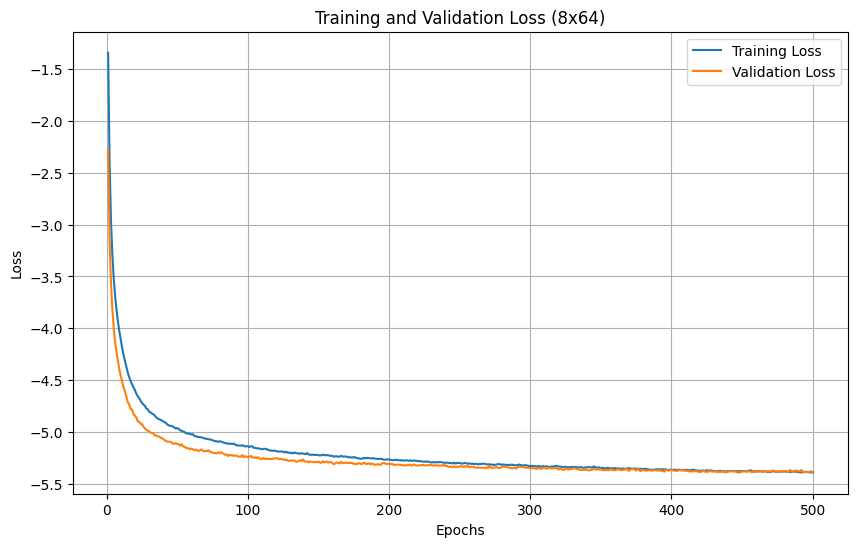

In [ ]:
Nt = 64
Nr = 8

path = f'/content/drive/MyDrive/Datasets/test/10dB/8x64/train'
H, H_est = mat_load_train(path)

if H is None or H_est is None:
    import sys
    sys.exit()
else:
# -----------------------
#  Construct the BFNN Model
# -----------------------
    H_input_real = np.real(H_est).reshape(H_est.shape[0], -1)
    H_input_imag = np.imag(H_est).reshape(H_est.shape[0], -1)
    H_input = np.concatenate([H_input_real, H_input_imag], axis=1)
    print(f"Shape của H_input (imperfect CSI đã xử lý): {H_input.shape}")
    print(f"Shape của H (perfect CSI): {H.shape}")

    SNR = np.power(10, np.random.randint(-20, 20, [H.shape[0], 1]) / 10).astype(np.float32)
    print(f"Shape của SNR: {SNR.shape}")

    model_8x64 = create_8x64_model()
    # Compile model
    optimizer = Adam(learning_rate=0.001) # Hoặc learning rate bạn chọn
    model_8x64.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)

    print("\n--- Model Summary cho 8x64 ---")
    model_8x64.summary()

    # --- Train Model ---
    checkpoint_filepath = f'/content/drive/MyDrive/Datasets/test/10dB/8x64/8x64_10dB.weights.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        save_weights_only=True
    )

    dummy_y = np.zeros((H_input.shape[0], 1))

    print(f"\nBắt đầu huấn luyện model cho cấu hình {Nr}x{Nt}...")
    history = model_8x64.fit(x=[H_input, H, SNR],
                        y=dummy_y,
                        batch_size=256,
                        epochs=500,
                        verbose=2,
                        validation_split=0.1,
                        callbacks=[checkpoint]
                       )

    print(f"Đã huấn luyện xong. Trọng số tốt nhất được lưu tại: {checkpoint_filepath}")
        # --- Vẽ Đồ Thị Loss ---
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs_range = range(1, len(training_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss ({Nr}x{Nt})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

**Test 8x64**


--- Model Summary được xây dựng lại cho 8x64 ---
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imperfect_CSI_input (Input  [(None, 1024)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 dense_1 (Dense)             (None, 1024)                 1049600   ['imperfect_CSI_input[0][0]'] 
                                                                                                  
 bn_1 (BatchNormalization)   (None, 1024)                 4096      ['dense_1[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 1024) 


Đã tải trọng số từ: /content/drive/MyDrive/Datasets/test/10dB/8x64/8x64_10dB.weights.h5
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (10000, 8, 64)

Bắt đầu đánh giá trên tập test...
SNR: -20dB, Loss (Negative SE): -0.8362618088722229
SNR: -15dB, Loss (Negative SE): -1.6437695026397705
SNR: -10dB, Loss (Negative SE): -2.699007749557495
SNR: -5dB, Loss (Negative SE): -3.9158754348754883
SNR: 0dB, Loss (Negative SE): -5.251380920410156
SNR: 5dB, Loss (Negative SE): -6.687224864959717
SNR: 10dB, Loss (Negative SE): -8.205809593200684
SNR: 15dB, Loss (Negative SE): -9.783935546875
SNR: 20dB, Loss (Negative SE): -11.399506568908691

Kết quả Spectral Efficiency trên tập test: [0.8362618088722229, 1.6437695026397705, 2.699007749557495, 3.9158754348754883, 5.251380920410156, 6.687224864959717, 8.205809593200684, 9.783935546875, 11.399506568908691]


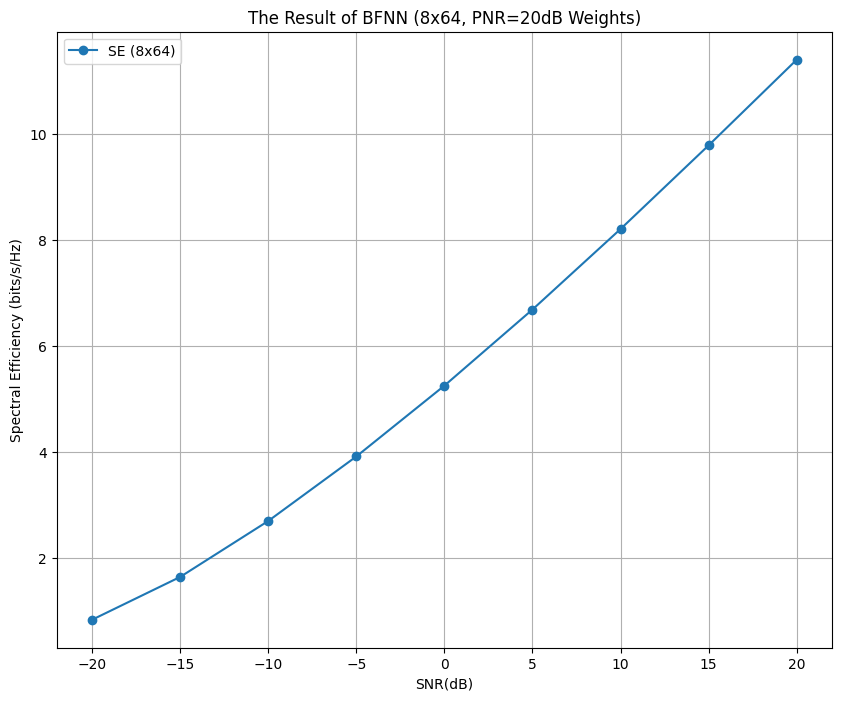

In [ ]:
Nt = 64
Nr = 8
PNR_for_weights = 20

# ---  MODEL 8x64 ---
model_for_test = create_8x64_model()

# Compile model
optimizer = Adam(learning_rate=0.001)
model_for_test.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
print("\n--- Model Summary được xây dựng lại cho 8x64 ---")
model_for_test.summary()


# --- TẢI TRỌNG SỐ VÀ CHUẨN BỊ DỮ LIỆU TEST ---
weights_path = f'/content/drive/MyDrive/Datasets/test/10dB/8x64/8x64_10dB.weights.h5'
try:
    model_for_test.load_weights(weights_path)
    print(f"\nĐã tải trọng số từ: {weights_path}")
except Exception as e:
    print(f"\nLỖI khi tải trọng số: {e}. Hãy đảm bảo đường dẫn đúng và kiến trúc model khớp.")
else:
    path_test_data = f'/content/drive/MyDrive/Datasets/test/10dB/8x64/test'
    H_test_perfect, H_test_estimated = mat_load_train(path_test_data)

    if H_test_perfect is not None and H_test_estimated is not None:
        # Chuẩn bị H_input_for_testing (imperfect CSI)
        H_input_test_real = np.real(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
        H_input_test_imag = np.imag(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
        H_input_for_testing = np.concatenate([H_input_test_real, H_input_test_imag], axis=1)

        # Chuẩn bị dummy_y cho dữ liệu test
        num_test_samples = H_input_for_testing.shape[0]
        dummy_y_test = np.zeros((num_test_samples, 1))

        # --- THỰC HIỆN TEST ---
        rate_results = []
        snr_db_range = range(-20, 21, 5)

        print("\nBắt đầu đánh giá trên tập test...")
        for snr_db_value in snr_db_range:
            # Đổi tên biến SNR trong vòng lặp để tránh nhầm lẫn với SNR training
            SNR_for_evaluation = np.power(10, np.ones([num_test_samples, 1]) * snr_db_value / 10.0).astype(np.float32)

            y_eval = model_for_test.evaluate(
                x=[H_input_for_testing, H_test_perfect, SNR_for_evaluation],
                y=dummy_y_test, # Sử dụng dummy_y
                batch_size=10000,
                verbose=0
            )
            print(f"SNR: {snr_db_value}dB, Loss (Negative SE): {y_eval}")
            rate_results.append(-y_eval)

        print("\nKết quả Spectral Efficiency trên tập test:", rate_results)

        # --- VẼ ĐỒ THỊ ---
        plt.figure(figsize=(10, 8))
        plt.title(f"The Result of BFNN ({Nr}x{Nt}, PNR={PNR_for_weights}dB Weights)")
        plt.xlabel("SNR(dB)")
        plt.ylabel("Spectral Efficiency (bits/s/Hz)")
        plt.plot(list(snr_db_range), rate_results, marker='o', linestyle='-', label=f'SE ({Nr}x{Nt})')
        plt.xticks(list(snr_db_range))
        plt.legend()
        plt.grid(True)
        plt.show()

#Plot figure

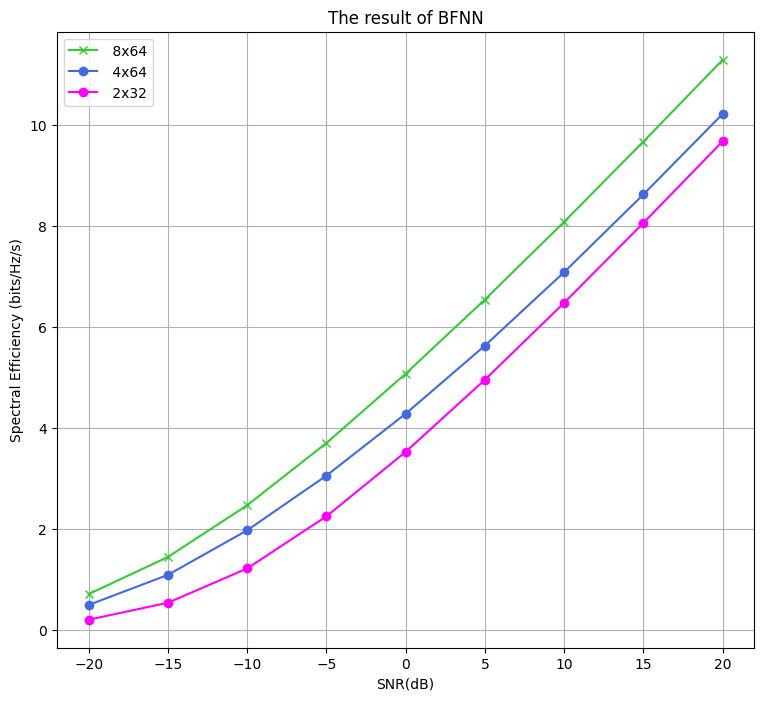

In [ ]:
rate2x32_10dB = [0.19714190065860748, 0.5334809422492981, 1.2125340700149536, 2.2450549602508545, 3.5237624645233154, 4.9534912109375, 6.478175640106201, 8.061477661132812, 9.678894996643066] #2x32 10dB
rate4x64_10dB = [0.48936381936073303, 1.085632085800171, 1.9684693813323975, 3.0524563789367676, 4.279143810272217, 5.628354072570801, 7.08534049987793, 8.625697135925293, 10.221379280090332] #4x64 10dB
rate8x64_10dB = [0.8362618088722229, 1.6437695026397705, 2.699007749557495, 3.9158754348754883, 5.251380920410156, 6.687224864959717, 8.205809593200684, 9.783935546875, 11.399506568908691] #8x64 10dB

# Trục x
snr_axis = list(range(-20, 25, 5))

# Vẽ đồ thị
plt.figure(figsize=(9, 8))
plt.title("The result of BFNN")
plt.xlabel("SNR(dB)")
plt.ylabel("Spectral Efficiency (bits/Hz/s)")

plt.grid(True)


plt.plot(snr_axis, rate8x64_10dB, color = "limegreen", marker ='x', linestyle = '-', label = ' 8x64')

plt.plot(snr_axis, rate4x64_10dB, color = 'royalblue', marker='o', linestyle='-', label=' 4x64')

plt.plot(snr_axis, rate2x32_10dB, color = 'fuchsia', marker='o', linestyle='-', label=' 2x32')


# legend
plt.legend()
plt.xticks(snr_axis)

# plt.xlim(min(snr_axis), max(snr_axis))
# plt.ylim(min(rate_neg20), max(rate20) + 2)

plt.show()

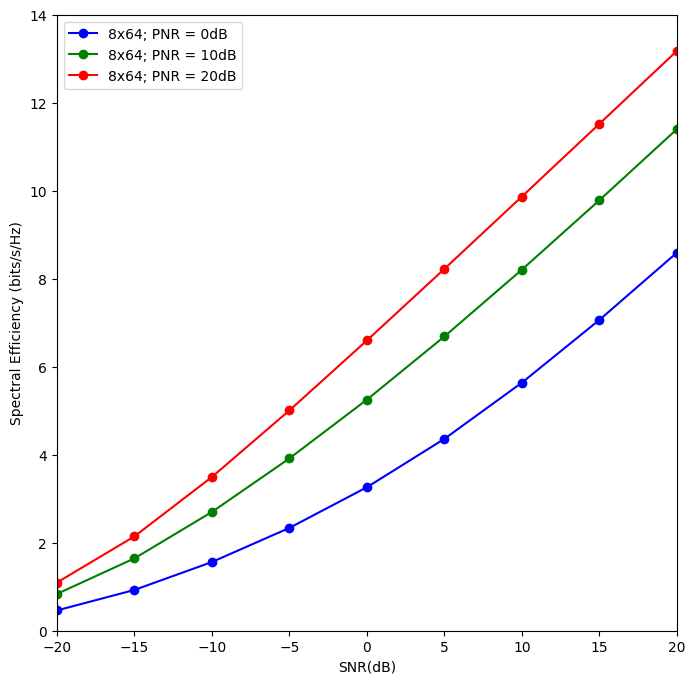

In [ ]:
rate2x32_20dB = [0.22231677174568176, 0.6007986068725586, 1.3621245622634888, 2.511411666870117, 3.9143946170806885, 5.449006080627441, 7.047856330871582, 8.677835464477539, 10.322870254516602]

rate2x32_10dB = [0.19714190065860748, 0.5334809422492981, 1.2125340700149536, 2.2450549602508545, 3.5237624645233154, 4.9534912109375, 6.478175640106201, 8.061477661132812, 9.678894996643066]

rate2x32_0dB = [0.13466759026050568, 0.37008222937583923, 0.8648051023483276, 1.6590361595153809, 2.70100474357605, 3.9321539402008057, 5.310042858123779, 6.794956207275391, 8.35078239440918]

rate4x64_20dB = [0.6248572468757629, 1.3946508169174194, 2.542872190475464, 3.9421160221099854, 5.4736456871032715, 7.069481372833252, 8.696797370910645, 10.340130805969238, 11.991827011108398]

rate4x64_10dB = [0.48936381936073303, 1.085632085800171, 1.9684693813323975, 3.0524563789367676, 4.279143810272217, 5.628354072570801, 7.08534049987793, 8.625697135925293, 10.221379280090332]

rate4x64_0dB =  [0.29207703471183777, 0.6603565812110901, 1.2291613817214966, 1.9675570726394653, 2.865300416946411, 3.9380040168762207, 5.189822673797607, 6.594313144683838, 8.108087539672852]

rate8x64_0dB = [0.46111631393432617, 0.9269291162490845, 1.5614417791366577, 2.336597204208374, 3.261181116104126, 4.3602118492126465, 5.63800573348999, 7.064423561096191, 8.592753410339355]

rate8x64_10dB = [0.8362618088722229, 1.6437695026397705, 2.699007749557495, 3.9158754348754883, 5.251380920410156, 6.687224864959717, 8.205809593200684, 9.783935546875, 11.399506568908691]

rate8x64_20dB = [1.0949630737304688, 2.143160581588745, 3.4938063621520996, 5.0071234703063965, 6.597315788269043, 8.223677635192871, 9.867786407470703, 11.520753860473633, 13.178032875061035]

snr_axis = list(range(-20, 25, 5))

# Vẽ đồ thị
plt.figure(figsize=(8, 8))

plt.xlabel("SNR(dB)")
plt.ylabel("Spectral Efficiency (bits/s/Hz)")

plt.grid(False)


# plt.plot(snr_axis, rate2x32_20dB, color = 'red', marker='o', linestyle='-', label='2x32; PNR = 20dB')

# plt.plot(snr_axis, rate2x32_10dB, color = 'green', marker='o', linestyle='-', label='2x32; PNR = 10dB')

# plt.plot(snr_axis, rate2x32_0dB, color = 'blue', marker='o', linestyle='-', label='2x32; PNR = 0dB')

# plt.plot(snr_axis, rate4x64_20dB, color = 'red', marker='o', linestyle='-', label='4x64; PNR = 20dB')

# plt.plot(snr_axis, rate4x64_10dB, color = 'green', marker='o', linestyle='-', label='4x64; PNR = 10dB')

# plt.plot(snr_axis, rate4x64_0dB, color = 'blue', marker='o', linestyle='-', label='4x64; PNR = 0dB')

plt.plot(snr_axis, rate8x64_0dB, color = 'Blue', marker='o', linestyle='-', label='8x64; PNR = 0dB')

plt.plot(snr_axis, rate8x64_10dB, color = 'green', marker='o', linestyle='-', label='8x64; PNR = 10dB')

plt.plot(snr_axis, rate8x64_20dB, color = 'Red', marker='o', linestyle='-', label='8x64; PNR = 20dB')
# legend
plt.legend()
plt.xticks(snr_axis)
plt.xlim(min(snr_axis), max(snr_axis))
plt.ylim(0, 14)
plt.show()